In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import deque

In [360]:
df_breaks = pd.read_pickle('..//data//simulated_breaks_ix.pickle')
df_returns = pd.read_pickle('..//data//simulated_returns.pickle')
df_highest_sharp = pd.read_pickle('..//data//highest_shape_ratios.pickle')
df_true_sharp = pd.read_pickle('..//data//sharp_ratios.pickle')

In [22]:
#f_highest_sharp

In [23]:
rf = 7.85849419846496e-05

In [447]:
class RollingSharp():
    
    def __init__(self, riskfree_rate, window=20):
        self.obs = deque(list(), window)
        self.window = window
        self.riskfree_rate = riskfree_rate
        
    def __repr__(self):
        return str(self.obs)
    
    @property
    def mean(self):
        return np.mean(self.obs) - self.riskfree_rate
    
    @property
    def std(self):
        
        std = np.std(self.obs)
        if std == 0.0:
            return 0.01
        return std
    
    def sharp_ratio(self):
        return self.mean / self.std
    
    def pred(self, x):
        self.obs.append(x)
        return self.sharp_ratio()
        
        

In [448]:
class RollingSharpDecayingMean(RollingSharp):
    
    def __init__(self, riskfree_rate, window):
        super().__init__(riskfree_rate, window)
        
    @staticmethod
    def calc_weights(n):
        return np.arange(1, n+1) / (((n+1) * n) / 2)
        
    @property
    def mean(self):
        n = len(self.obs)
        weights = self.calc_weights(n)
        return np.dot(weights, np.array(self.obs))

In [462]:
_start, _end = 0, 5000

hyper_params = [50, 100, 150, 200, 250, 300]
mse_list = list()

for h in hyper_params:
    df_dict = {}

    for col in df_returns.columns:
        rs = RollingSharp(rf, window=h)
        res = list(map(rs.pred, df_returns[col][_start:_end]))
        df_dict[col] = res

    rolling_sharp = pd.DataFrame(df_dict)
    mse = ((df_true_sharp.iloc[start: end] - rolling_sharp)**2).mean(axis=1).mean()
    mse_list.append(mse)

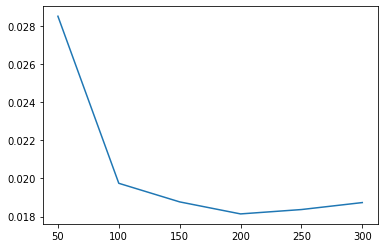

In [464]:
plt.plot(hyper_params, mse_list)  

In [465]:
df_dict = {}

for col in df_returns.columns:
    rs = RollingSharp(rf, window=200)
    res = list(map(rs.pred, df_returns[col][_start:_end]))
    df_dict[col] = res

rolling_sharp = pd.DataFrame(df_dict)
mse = ((df_true_sharp.iloc[start: end] - rolling_sharp)**2).mean(axis=1).mean()

In [466]:
mse

0.018136779715155416

In [186]:
from functools import partial
def is_highest(x, row):
    if x == max(row):
        return 1
    else:
        return 0
    
def dummy_highest_val(row):
    
    return list(map(partial(is_highest, row=row), row))

In [187]:
highest_rolling_sharp = rolling_sharp.apply(dummy_highest_val, axis=1, result_type='broadcast')

In [188]:
res = ((highest_rolling_sharp - df_highest_sharp.iloc[0:1000])**2).sum(axis=1) / 2

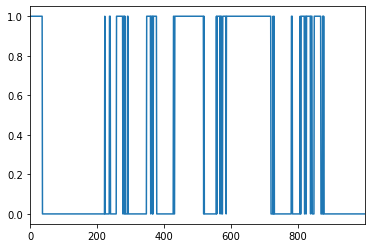

In [189]:
res.plot()

### RollingSharpRatioLSTM

Attempting to make a rolling scheme of finding sharp ratio

In [446]:
class RollingSharpLSTM():
    
    def __init__(self, riskfree_rate, long_window=50, short_window=10, threshold=0.5):
        self.long_mem = deque(list(), long_window)
        self.short_mem = deque(list(), short_window)
        self.short_window = short_window
        self.long_window = long_window
        self.riskfree_rate = riskfree_rate
        self.log_swap = list()
        self.iter = 0
        self.threshold = threshold
        
    def __repr__(self):
        return str(self.long_mem)
        
    @staticmethod
    def calc_sharp(mem, rf):
        lm_df = pd.DataFrame(mem)
        res = (lm_df.mean(axis=0) - rf) / lm_df.std(axis=0)
        return res.fillna(0.1)
    
    def long_sharp(self):
        return self.calc_sharp(self.long_mem, self.riskfree_rate)
    
    def short_sharp(self):
        return self.calc_sharp(self.short_mem, self.riskfree_rate)
    
    def swap_memory(self):
        """Replacing old long term memory with short term"""
        self.long_mem = deque(list(self.short_mem), self.long_window)
        self.log_swap.append(self.iter)
        
    def calc_squared_distance(self, x):
        self.long_mem.append(x)
        self.short_mem.append(x)
        return np.mean((self.long_sharp() - self.short_sharp())**2)

    def pred(self, x):
        self.iter += 1
        dist = self.calc_squared_distance(x)
        if dist > self.threshold:
            self.swap_memory()
            
        return self.long_sharp()

In [445]:
names = {stock_n : f's_{stock_n + 1}'  for stock_n in range(11)}
names

{0: 's_1',
 1: 's_2',
 2: 's_3',
 3: 's_4',
 4: 's_5',
 5: 's_6',
 6: 's_7',
 7: 's_8',
 8: 's_9',
 9: 's_10',
 10: 's_11'}

In [405]:
((df_true_sharp.iloc[start: end] - res)**2).mean(axis=1).mean()

0.02907801918630403

In [407]:
# Optimizing hyper parameters

In [419]:
hyper_parameters = list()
for _threshold in [0.3, 0.5, 0.8]:
    for _long_window in [50, 100, 150]:
        for _short_window in [15, 30, 45]:
            hyper_parameters.append((_threshold, _long_window, _short_window)) 

In [422]:
# set period of calculating
start, end = 0, 3000

results = []

#hyper parameters:
for hp in hyper_parameters:  
        
    # predicting sharp ratio
    rs_lstm = RollingSharpLSTM(rf, threshold=hp[0], long_window=hp[1], short_window=hp[2])
    res = list(map(rs_lstm.pred, np.array(df_returns.iloc[start:end])))        
    res = pd.DataFrame(res)

    # calculating mse
    res.rename(names, axis=1, inplace=True)
    mse = ((df_true_sharp.iloc[start: end] - res)**2).mean(axis=1).mean()

    results.append((mse, hp[0], hp[1], hp[2]))
        
    print('iter over')

iter over
iter over
iter over
iter over
iter over
iter over
iter over
iter over
iter over
iter over
iter over
iter over
iter over
iter over
iter over
iter over
iter over
iter over
iter over
iter over
iter over
iter over
iter over
iter over
iter over
iter over
iter over


In [423]:
#df_hyperparameters = pd.DataFrame(results)

In [425]:
#df_hyperparameters.to_pickle('..//data//hyperparameter_tuning.pickle')

In [427]:
df_hyperparameters.columns = ['mse', 'threshold', 'long window', 'short window']

In [429]:
df_hyperparameters.loc[df_hyperparameters['mse'].min() == df_hyperparameters['mse']]

,mse,threshold,long window,short window
7,0.015622,0.3,150,30


In [488]:
start, end = 0, 5000
rs_lstm = RollingSharpLSTM(rf, threshold=0.3, long_window=150, short_window=30)
res = list(map(rs_lstm.pred, np.array(df_returns.iloc[start:end])))
breaks = df_breaks.loc[(df_breaks.break_ix <= end) & (df_breaks.break_ix >= start)]

In [489]:
rs_lstm.log_swap

[2724]

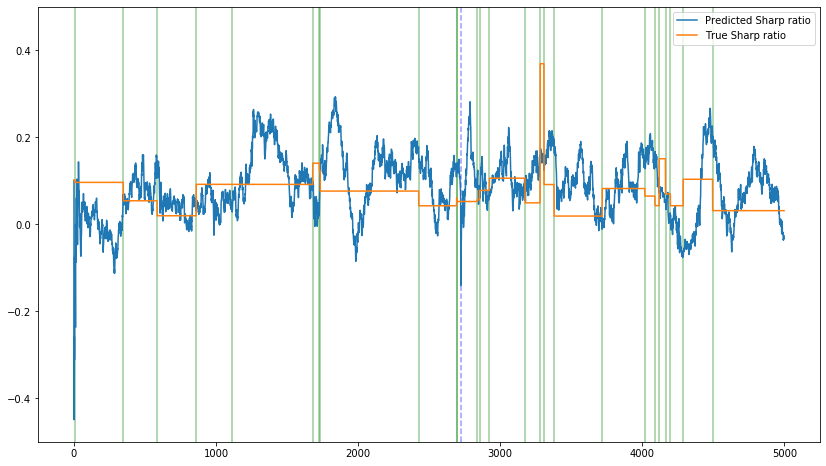

In [490]:
stock_n = 4
_res = pd.DataFrame(res)

f, ax = plt.subplots(1, 1, figsize=(14,8))

for b in breaks['break_ix']:
    ax.axvline(b, color='green', alpha=0.4)
    
for swap in rs_lstm.log_swap:
    ax.axvline(swap + start, color='blue', ls='--', alpha=0.4)

ax.plot(range(start,end),_res[stock_n], label='Predicted Sharp ratio')
ax.set_ylim(-0.5, 0.5)
ax.plot(df_true_sharp[f's_{stock_n + 1}'][start: end], label = 'True Sharp ratio')
ax.legend()

In [491]:
f.savefig('..//figures//rolling_sharp_prediction_simulated.png')

In [492]:
res = _res.rename(names, axis=1)
mse = ((df_true_sharp.iloc[start: end] - res)**2).mean(axis=1).mean()

In [493]:
mse

0.013119228560626748